In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../hcr-ff/")
from plot_utils import *
from genome_utils import *

# General Setup

To start, I'm going to setup a handy utility function to check overlaps.
Then I'm going to start to collect data from the various files generated 
by the analysis pipeline. I'll also bring in some reference data, like 
local gene defs and epigenetics data.

The `*detailed.txt` files contain guide-wise sorting bin counts from our HCR FlowFISH experiments. 

The `FULCO__GATA*_10p.txt` are derived from the Activity-By-Contact (ABC) paper (Fulco et. al. 2019); 
these data are a simplification of the 6-way sorting procedure. We basically decided to only use the 
two extreme expression bins (lowest 10% and highest 10%) and only the first PCR replicate for each 
biological replicate. This makes the ABC paper data compareable to our HCR FlowFISH experiments, and 
allows us compare performance of our peak-caller on similar experiments. We lifted over guide coordinates 
from `GuideInfo.tsv` in the ABC supplement to determine hg38 coordinates, and because strand information was 
not provided by the authors, we had to make the simplifying assumption that all guides are on the positive 
strand.

The `Join_PanGATA*.txt` file is an in-house collation of our experiments and the CRISPRi Growth Screen 
data from Fulco et. al. 2016. It's also lifted over to hg38, but the strand information should be more accurate 
than the `GuideInfo.tsv` liftover.

In [2]:
G1R1_fn = '../data/GATA1_rep2detailed.txt'
G1R2_fn = '../data/GATA1_rep5detailed.txt'

H6R1_fn = '../data/HDAC_rep7detailed.txt'
H6R2_fn = '../data/HDAC_rep8detailed.txt'

ABC1_fn = '../data/FULCO__GATA1_rep1_10p.txt'
ABC2_fn = '../data/FULCO__GATA1_rep2_10p.txt'
ABC3_fn = '../data/FULCO__GATA1_rep3_10p.txt'

FULC_fn = '../data/Join_PanGATA__GATA_CRISPRI_growth___GUIDESCAN_annotated.txt'

fn_list = [G1R1_fn,G1R2_fn,H6R1_fn,H6R2_fn,ABC1_fn,ABC2_fn,ABC3_fn]

exp_ids = ['G1R1','G1R2','H6R1','H6R2','ABC1','ABC2','ABC3','FUL1','FUL2']

fullinfo= [("GATA1",1), ("GATA1",2), ("HDAC6",1), ("HDAC6",2), 
           ("ABC",1), ("ABC",2), ("ABC",3), ("Fulco",1), ("Fulco",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['Ref1'] = ('Growth paper', 1)
id2info['Ref2'] = ('ABC paper', 1)
id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

### Get peak calls from different experiments

Now I'm going to walk through the different peak files that we have and collect them into one DataFrame. Here's the rundown:

- `../data/GATA1_rep*__mergedPeaks.bed`    -> HCR-FlowFISH experiment, our analysis
- `../data/HDAC6_rep*__mergedPeaks.bed`    -> HCR-FlowFISH experiment, our analysis
- `../data/ABC_rep*__sigPeaks.bed`         -> Fulco 2019 experiment, our analysis
- `../data/Fulco_GATA_enhancer_filter.bed` -> Peaks we got from Lander lab when we asked for Fulco 2016 peaks
- `../data/ABC_paperPeaks_hg38.bed`        -> Fulco 2019 experiment, significant GATA peaks per their analysis, I lifted over to hg38
- `../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed` -> H3K27ac peaks in hg38 that we cleaned up
- `../data/DNASE_peaks_replicated.bed`     -> DHS peaks in hg38 that we cleaned up

Regarding `Fulco_GATA_enhancer_filter.bed`: These are suspect, the peaks proximal to GATA1 are identical to the ABC paper peaks, though some peaks outside of the locus differ. 

In [3]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
G1R1_bed= '../data/GATA1_rep2__allPeaks.bed'
G1R2_bed= '../data/GATA1_rep5__allPeaks.bed'

H6R1_bed= '../data/HDAC_rep7__allPeaks.bed'
H6R2_bed= '../data/HDAC_rep8__allPeaks.bed'

ABC1_bed= '../data/ABC_rep1__allPeaks.bed'
ABC2_bed= '../data/ABC_rep2__allPeaks.bed'
ABC3_bed= '../data/ABC_rep3__allPeaks.bed'

FUL1_bed= '../data/Fulco_GATA_enhancer_filter.bed'
FUL2_bed= '../data/Fulco_GATA_enhancer_filter.bed'

exp_beds= [G1R1_bed, G1R2_bed, H6R1_bed, H6R2_bed,
           ABC1_bed, ABC2_bed, ABC3_bed, 
           FUL1_bed, FUL2_bed]

Ref1_bed= '../data/Fulco_GATA_enhancer_filter.bed'
Ref2_bed= '../data/ABC_paperPeaks_hg38.bed'
K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

extra_beds = [ Ref1_bed, Ref2_bed, K27_bed, DHS_bed ]
extra_tags = [ 'Ref1', 'Ref2', 'k27', 'DHS' ]

I'm using a truncated GFF file to specify the genes of interest in the region. TBH, I'm not 100% sure this is actually a GFF, but the table is displayed below so you understand how this file should be formatted if you are looking at a different locus. Off the top of my head, you WILL need to remove any trailing ","s in the `exonStarts` and `exonEnds` fields.

In [4]:
gff = pd.read_table('../data/GATA_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000376670.8,chrX,+,48786553,48794311,48791109,48794164,6,"48786553,48791090,48791843,48792322,48793171,4...","48786645,48791329,48792221,48792468,48793297,4...",P15976,ENST00000376670.8,GATA1
1,ENST00000376619.6,chrX,+,48802033,48824976,48802692,48824612,29,"48802033,48802662,48802870,48803127,48805437,4...","48802170,48802785,48802999,48803216,48805522,4...",Q9UBN7,ENST00000376619.6,HDAC6


### Get guide-wise score info from different experiments

Now I'm going to collect data from each of the guide-wise count files that are compatible with our peak caller. 

I'm going to bring in `log( Low_Expression_Counts / High_Expression_Counts )` as a summary statistic for each rep. This "score" will be high for regions we think are enhancers and low for repressors (either 1st order or otherwise).

In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )
    print(d_pt.shape)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(15337, 8)
(15337, 8)
(15339, 8)
(15339, 8)
(19107, 4)
(18595, 4)
(19226, 4)


In [7]:
data = pd.concat([ df.drop_duplicates(subset='Coordinates', keep='first').set_index('Coordinates') for df in data ],axis=1,join='outer',sort=False)

In [8]:
# Flip ABC data
data['ABC1'] = data['ABC1'] * -1
data['ABC2'] = data['ABC2'] * -1
data['ABC3'] = data['ABC3'] * -1

Now I'll append Fulco Growth data.

In [9]:
fulc = pd.read_table(FULC_fn, sep='\t', header=0)
fulc = fulc.loc[ fulc.loc[:,'FulcoCRISPRiGrowth_exo'] == 'FulcoCRISPRiGrowth', 
                 ('Fulco_CRISPRi_Growth_coords', 'Fulco_CRISPRi Score (rep1)', 'Fulco_CRISPRi Score (rep2)') ]
fulc.columns = ["Coordinates","FUL1","FUL2"]
fulc = fulc.set_index("Coordinates")
fulc = fulc.astype(float)
fulc['FUL1'] = fulc['FUL1'] * -1
fulc['FUL2'] = fulc['FUL2'] * -1

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [10]:
data = pd.concat([data, fulc], axis=1, sort=False)

Finally, we'll use the guide coordinates to specify the predicted Cas9 cut-site for each guide. This will allow us to plot guide activity clearly.

In [11]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

Let get some peak tracks. Notice, all experimental peaks MUST have 6 columns, like a standard BED. However, the 5th column must be a `python` `bool` (either `True` or `False`, case-sensitive). This is a significance flag.

In [12]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead.


Experimental track count: 9
Total track count: 13


# Explore the locus

Here we're setting up a plotting function to look all all of the data from each replicate of each experiment that we specify. We're going to plot guide-wise scores at the cutsites and plot peaks on a track above.

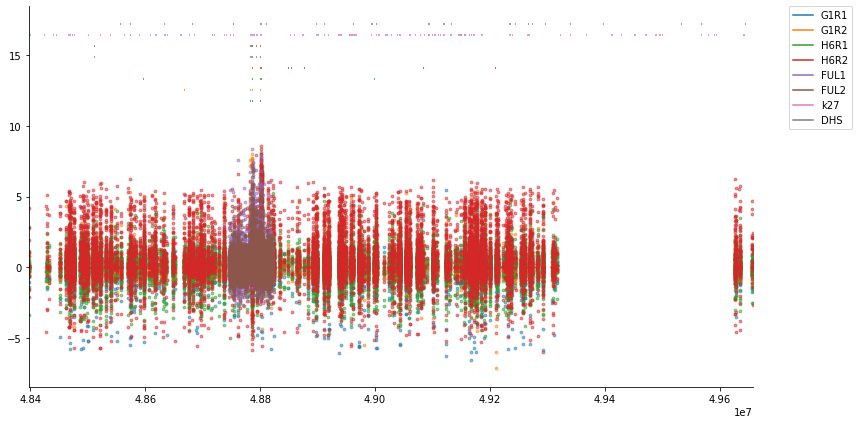

In [13]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


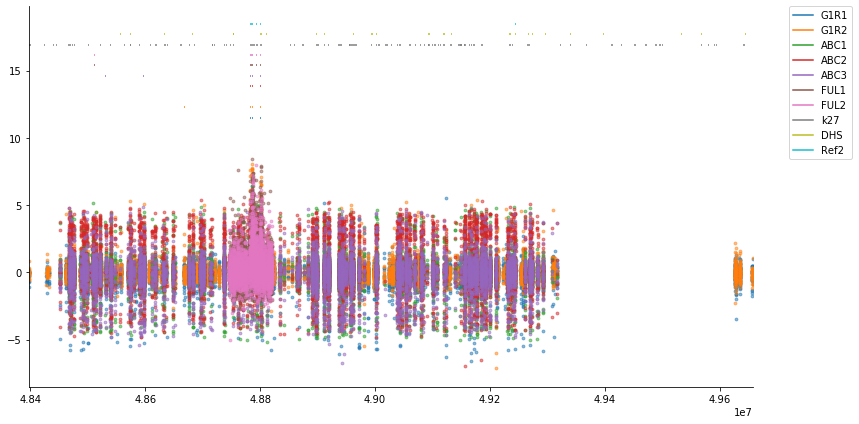

In [14]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48397729,49657309]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


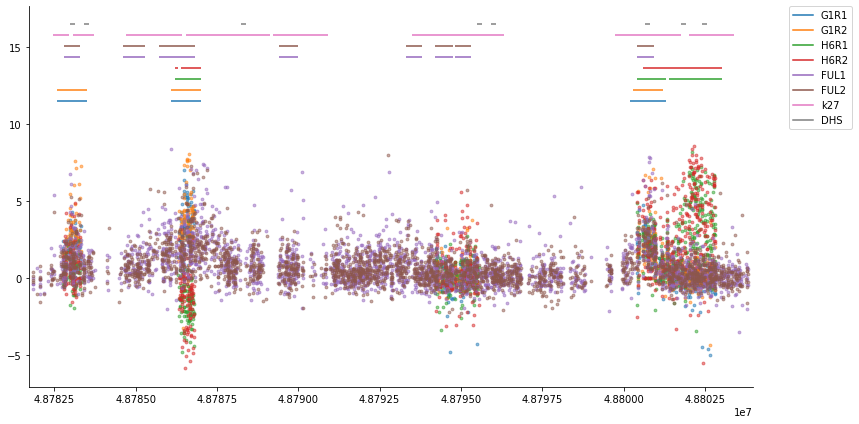

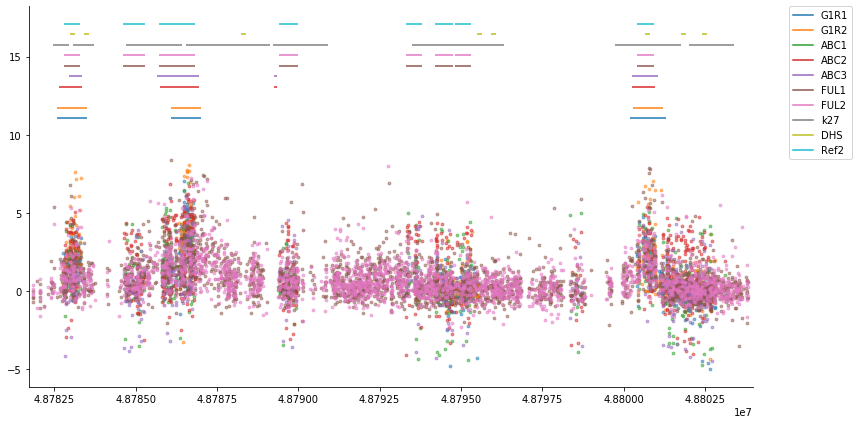

In [15]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])

fig_h, ax_h = plot_hff_cutsites(np.array([[48781722,48803966]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','FUL1','FUL2','k27','DHS','Ref2'])


GATA1
18
HDAC6
21
Fulco
3
GATA1
18
ABC
25


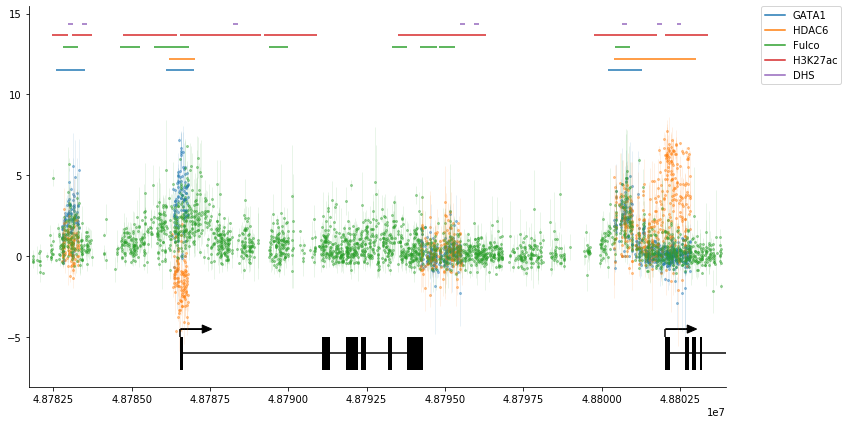

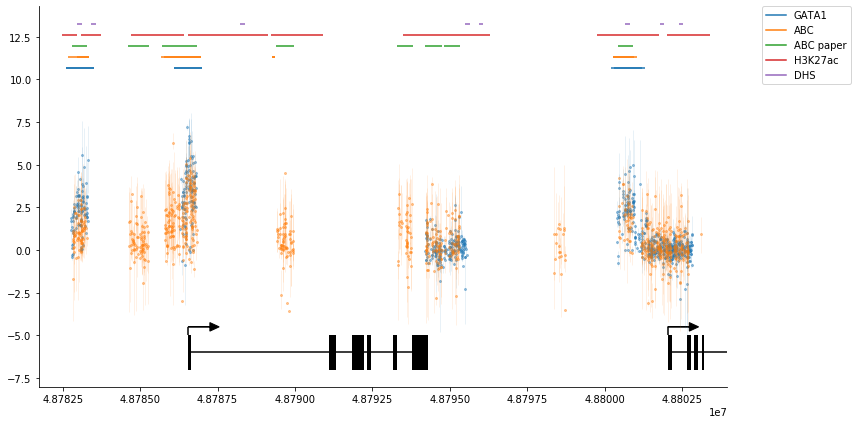

In [36]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300])
fig_h.savefig('GATA_locus__48781722_48803966__all.pdf')

fig_h, ax_h = plot_combined_cutsites(np.array([[48781722,48803966]]), 
                               data, test_peaks, plot_ids=['G1R1','G1R2','ABC1','ABC2','ABC3','Ref2','k27','DHS'],
                               merge_style='overlap')
draw_genes_from_gff(ax_h, gff, promoter_params=[700,0.5,300])

fig_h.savefig('GATA_locus_with_ABC__48781722_48803966__all.pdf')


GATA1
334
HDAC6
506
Fulco
4


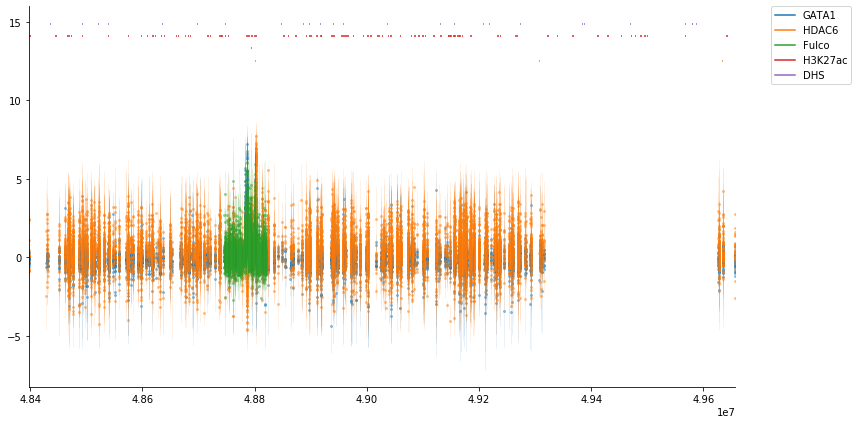

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48397729,49657309]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])


GATA1
2
HDAC6
2
Fulco
0


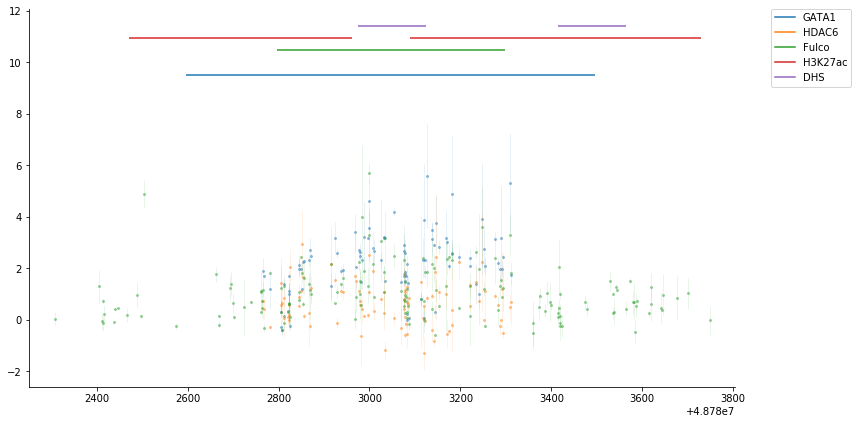

In [18]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48782251,48783805]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48782251_48783805__all.pdf')

GATA1
1
HDAC6
1
Fulco
1


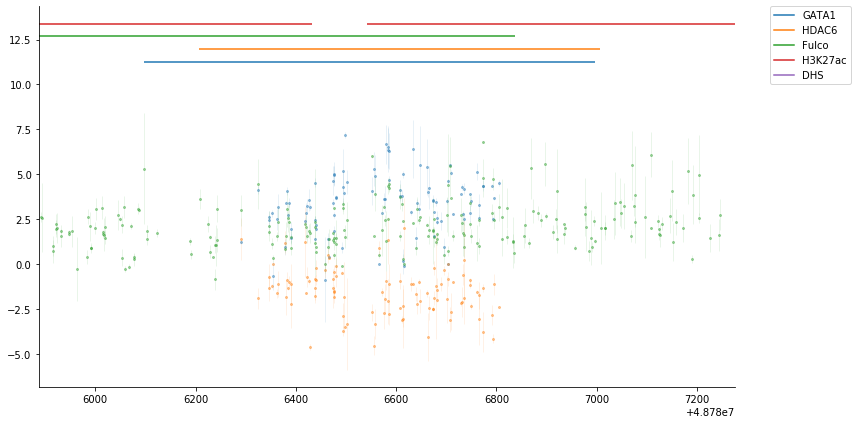

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48785887,48787277]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48785887_48787277__all.pdf')

GATA1
13
HDAC6
13
Fulco
1


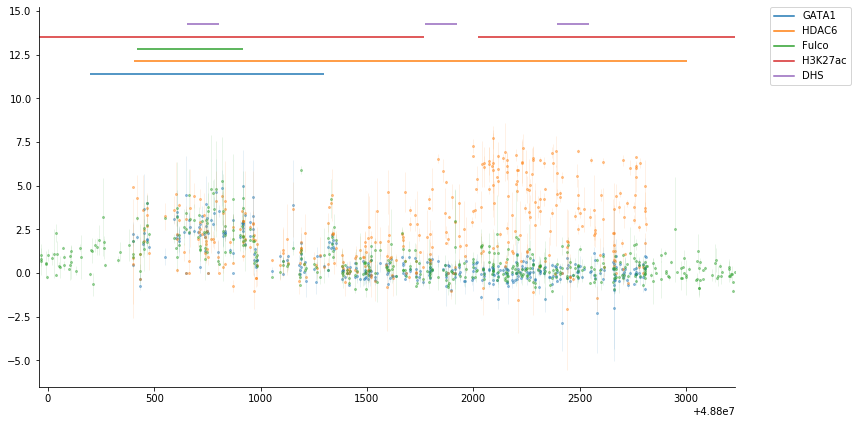

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48799956,48803233]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48799956_48803233__all.pdf')

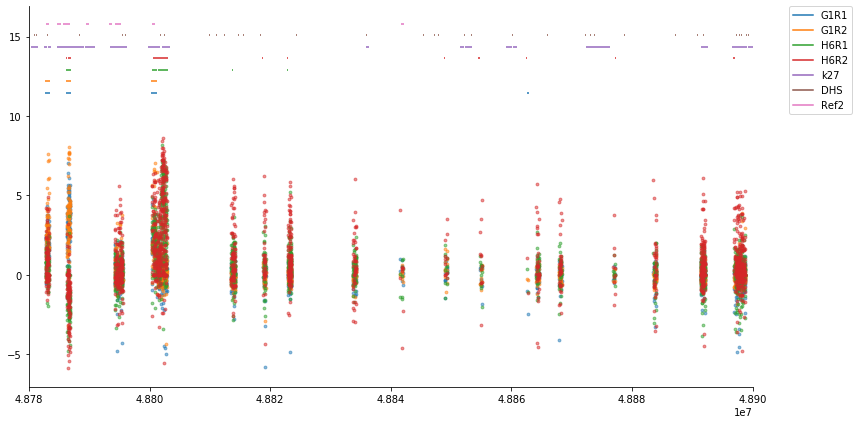

In [21]:
fig_h, ax_h = plot_hff_cutsites(np.array([[48780000,48900000]]), 
          data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','k27','DHS','Ref2'])


GATA1
36
HDAC6
51
Fulco
3


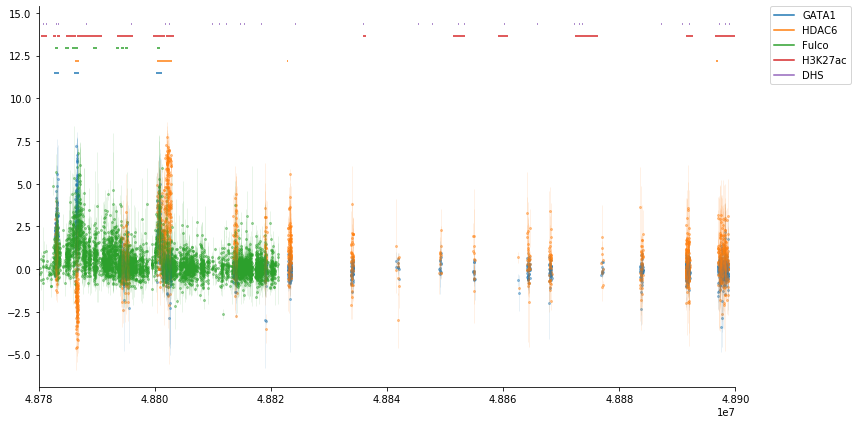

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[48780000,48900000]]), 
                  data, test_peaks, plot_ids=['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','k27','DHS'])
fig_h.savefig('GATA_locus__48780000_48900000__all.pdf')

# Connection Diagrams

In [23]:
txn_starts = extract_txn_starts(gff)

In [24]:
all_locus_peaks = get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'GATA1') | \
                                                    (test_peaks['assay'] == 'HDAC6')] )

In [25]:
get_replicating_peaks( test_peaks[ test_peaks['assay'] == 'HDAC6' ] )

,chr,start,end
0,chrX,48522706,48522806
1,chrX,48550506,48550806
2,chrX,48776906,48777006
3,chrX,48786206,48787006
4,chrX,48800406,48803006
5,chrX,48822806,48822906
6,chrX,48896706,48897006
7,chrX,49237906,49238006
8,chrX,49307706,49308006
9,chrX,49310206,49310306


In [47]:
# GATA1
## rep 1
GATA1_rep1_scores = pd.read_table('../data/GATA1_rep2__allPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
GATA1_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in GATA1_rep1_scores['hdr'] ]

GATA1_rep1_scores['score'] = GATA1_rep1_scores['score'] - GATA1_rep1_scores['score'].median()

## rep 2
GATA1_rep2_scores = pd.read_table('../data/GATA1_rep5__allPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
GATA1_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in GATA1_rep2_scores['hdr'] ]

GATA1_rep2_scores['score'] = GATA1_rep2_scores['score'] - GATA1_rep2_scores['score'].median()

## combine
GATA1_total_scores = GATA1_rep1_scores.reset_index(drop=True).copy()
GATA1_total_scores['pass'] = np.array(GATA1_rep1_scores['pass'] & GATA1_rep2_scores['pass'])
GATA1_total_scores['score'] = (GATA1_rep1_scores['score'] + GATA1_rep2_scores['score']) / 2
GATA1_total_scores = GATA1_total_scores[ GATA1_total_scores['chr'] == 'chrX' ]

# HDAC6
## rep 1
HDAC6_rep1_scores = pd.read_table('../data/HDAC_rep7__allPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
HDAC6_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in HDAC6_rep1_scores['hdr'] ]

HDAC6_rep1_scores['score'] = HDAC6_rep1_scores['score'] - HDAC6_rep1_scores['score'].median()

## rep 2
HDAC6_rep2_scores = pd.read_table('../data/HDAC_rep8__allPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
HDAC6_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in HDAC6_rep2_scores['hdr'] ]

HDAC6_rep2_scores['score'] = HDAC6_rep2_scores['score'] - HDAC6_rep2_scores['score'].median()

## combine
HDAC6_total_scores = HDAC6_rep1_scores.reset_index(drop=True).copy()
HDAC6_total_scores['pass'] = np.array(HDAC6_rep1_scores['pass'] & HDAC6_rep2_scores['pass'])
HDAC6_total_scores['score'] = (HDAC6_rep1_scores['score'] + HDAC6_rep2_scores['score']) / 2
HDAC6_total_scores = HDAC6_total_scores[ HDAC6_total_scores['chr'] == 'chrX' ]


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if sys.path[0] == '':
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [48]:
(HDAC6_rep1_scores['pass'] & HDAC6_rep2_scores['pass'])

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1706    False
1707    False
1708    False
1709    False
1710    False
1711    False
1712     True
1713    False
1714    False
1715    False
1716    False
1717    False
1718    False
1719    False
1720    False
1721    False
1722    False
1723    False
1724    False
1725    False
1726    False
1727    False
1728    False
1729    False
1730    False
1731    False
1732    False
1733    False
1734    False
1735    False
Name: pass, Length: 1736, dtype: bool

In [49]:
all_locus_peaks

,chr,start,end
0,chrX,48522706,48522806
1,chrX,48550506,48550806
2,chrX,48776906,48777006
3,chrX,48782597,48783497
4,chrX,48786097,48787006
5,chrX,48800197,48803006
6,chrX,48822806,48822906
7,chrX,48896706,48897006
8,chrX,49237906,49238006
9,chrX,49307706,49308006


In [50]:
HDAC6_rep1_scores[(HDAC6_rep1_scores['pass']==True) & (HDAC6_rep1_scores['start']>48777006)]

,chr,start,end,hdr,pass,strand,score
666,chrX,48786206,48786306,"-1.0696042765760208,-0.8954012200679942",True,.,-1.128097
667,chrX,48786306,48786406,"-0.951368421780276,-0.8086749766537623",True,.,-1.025616
668,chrX,48786406,48786506,"-1.1243264657896723,-1.0020694271144377",True,.,-1.208792
669,chrX,48786506,48786606,"-1.574103382241592,-1.4839150550614297",True,.,-1.674604
670,chrX,48786606,48786706,"-1.782607215124867,-1.700157814299684",True,.,-1.886977
671,chrX,48786706,48786806,"-1.9577517977831127,-1.857953639808591",True,.,-2.053447
672,chrX,48786806,48786906,"-1.998581631235617,-1.8908050777793466",True,.,-2.090288
673,chrX,48786906,48787006,"-2.131941989541227,-1.9691563278417892",True,.,-2.196144
693,chrX,48800406,48800506,"0.8539354869712659,1.0182083547808083",True,.,0.790477
694,chrX,48800506,48800606,"1.1314918161449152,1.2877723401320627",True,.,1.064038


In [51]:
HDAC6_rep2_scores[(HDAC6_rep2_scores['pass']==True) & (HDAC6_rep2_scores['start']>48777006)]

,chr,start,end,hdr,pass,strand,score
0,chr12,54300615,54300715,"0.8034829518722224,1.2409453201395997",True,.,0.851805
1,chr12,54300715,54300815,"0.7929465984137397,1.239897919052461",True,.,0.846013
658,chrX,48786206,48786306,"-0.8272594372859292,-0.7113427763664788",True,.,-0.939711
660,chrX,48786406,48786506,"-0.9538319759685485,-0.8739733412466067",True,.,-1.084312
661,chrX,48786506,48786606,"-1.481852109539359,-1.4239278083562734",True,.,-1.623299
662,chrX,48786606,48786706,"-1.8703808486961004,-1.8117581205533366",True,.,-2.011479
663,chrX,48786706,48786806,"-2.0765539434665174,-2.0105177860525973",True,.,-2.213945
664,chrX,48786806,48786906,"-2.1184305817691422,-2.0474847578657864",True,.,-2.253367
665,chrX,48786906,48787006,"-2.4889559416112297,-2.3670778500350598",True,.,-2.598426
687,chrX,48800606,48800706,"1.6089552956840396,1.7602415357895715",True,.,1.514189


In [52]:
HDAC6_total_scores

,chr,start,end,hdr,pass,strand,score
15,chrX,48397806,48397906,"-0.006502019048167829,0.1474308420092183",False,.,-0.067554
16,chrX,48397906,48398006,"-0.002124240267551411,0.14316635261367855",False,.,-0.039015
17,chrX,48398006,48398106,"0.08298493661286886,0.22916171056243795",False,.,0.002838
18,chrX,48398106,48398206,"0.08520601391329842,0.24474161989643664",False,.,0.295031
19,chrX,48398206,48398306,"0.4503797641756343,0.8662167485794431",False,.,0.500496
20,chrX,48398306,48398406,"0.5365304243645237,0.966922933047103",False,.,0.656171
21,chrX,48427206,48427306,"-1.021913063604709,0.2149200110387619",False,.,0.016893
22,chrX,48427306,48427406,"-1.0153933769255197,0.17048437996783355",False,.,-0.139956
23,chrX,48427406,48427506,"-1.004793462322488,0.15744652041027374",False,.,-0.139418
24,chrX,48427506,48427606,"-1.0148777226671826,0.16869199321926182",False,.,-0.159654


In [53]:
HDAC6_rep1_scores

,chr,start,end,hdr,pass,strand,score
0,chr12,54300615,54300715,"0.24902079759695994,0.9272494471563633",False,.,0.442541
1,chr12,54300715,54300815,"0.27911146404391507,0.9161706680254615",False,.,0.452047
2,chr12,54300815,54300915,"0.05585385472433268,0.6249063016505001",False,.,0.194786
3,chr12,54300915,54301015,"-0.3855478802882102,0.4669279429749601",False,.,-0.104904
4,chr12,54301015,54301115,"-0.9205516605599606,0.1609292999090035",False,.,-0.525406
5,chr12,54301115,54301146,"-0.9252264567635893,0.15073603851326672",False,.,-0.532840
6,chr19,12886959,12887059,"-1.386689084512314,-1.0836425658440434",True,.,-1.380760
7,chr19,12887059,12887159,"-1.4111477895567102,-1.0973913340291648",True,.,-1.399864
8,chr19,12887159,12887259,"-1.4024389076381911,-1.0950922301487063",True,.,-1.394360
9,chr19,12887259,12887359,"-1.4376086253811544,-1.1251620965198261",True,.,-1.426980


In [54]:
HDAC6_rep2_scores

,chr,start,end,hdr,pass,strand,score
0,chr12,54300615,54300715,"0.8034829518722224,1.2409453201395997",True,.,0.851805
1,chr12,54300715,54300815,"0.7929465984137397,1.239897919052461",True,.,0.846013
2,chr12,54300815,54300915,"0.5688576493050471,0.9870102586402086",False,.,0.607524
3,chr12,54300915,54301015,"-1.4842142062853172,-0.5237131012008596",False,.,-1.174373
4,chr12,54301015,54301115,"-1.9238672460192923,-0.516539485626416",False,.,-1.390613
5,chr12,54301115,54301146,"-1.896019717127241,-0.4528335905229504",False,.,-1.344836
6,chr19,12886959,12887059,"-0.436064313815796,-0.26731610609881795",False,.,-0.522100
7,chr19,12887059,12887159,"-0.43360312034304704,-0.28041658497381194",False,.,-0.527419
8,chr19,12887159,12887259,"-0.4403869561886609,-0.2730923784590683",False,.,-0.527149
9,chr19,12887259,12887349,"-0.427914324335597,-0.2584663244590287",False,.,-0.513600


Interval: 48522706-48522806, Score: 0.6094341132192517, Pass: False
      chr     start       end                                    hdr   pass  \
223  chrX  48522706  48522806  0.8025306720669936,1.6799400701426825  False   

    strand     score  
223      .  0.609434  
Interval: 48550506-48550806, Score: 0.7153735243155911, Pass: False
      chr     start       end                                        hdr  \
267  chrX  48550506  48550606      0.24130600193051585,0.716986709977915   
268  chrX  48550606  48550706  -0.0015655651502423096,1.1333650863725864   
269  chrX  48550706  48550806      0.7291495979863366,2.4391589996550094   

      pass strand     score  
267  False      .  0.173430  
268  False      .  0.237129  
269  False      .  0.715374  
Interval: 48776906-48777006, Score: 0.640689095941282, Pass: False
      chr     start       end                                    hdr   pass  \
649  chrX  48776906  48777006  0.9717655306271802,1.5430919001845256  False   

    stra

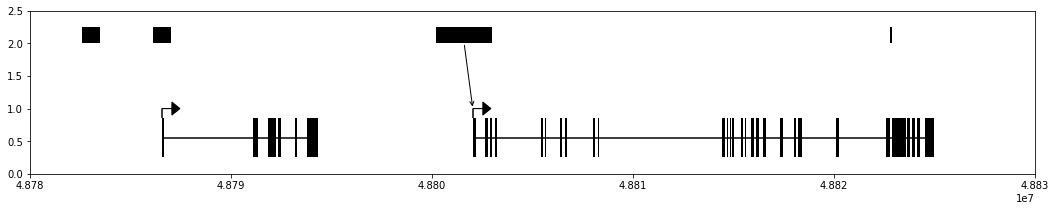

In [30]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [48780000,48830000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
#connect_bed_to_genes(ax, all_locus_peaks, txn_starts['GATA1'], y_anchor=2.0, y_target=1.0, score_bed=GATA1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['HDAC6'], y_anchor=2.0, y_target=1.0, score_bed=HDAC6_total_scores, xlims=glims)

plt.savefig('GATA_locus__48780000_48830000__connectogram.pdf')

plt.show()

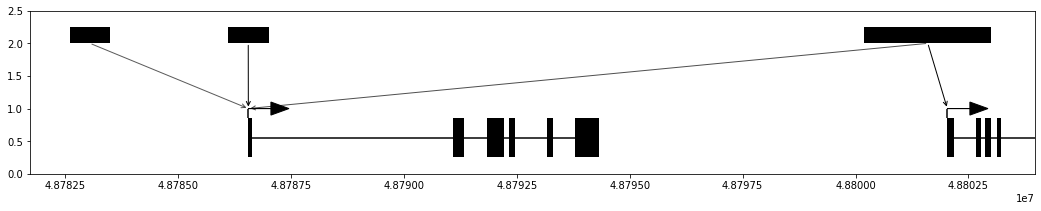

In [53]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [48781722,48803966]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['GATA1'], y_anchor=2.0, y_target=1.0, score_bed=GATA1_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['HDAC6'], y_anchor=2.0, y_target=1.0, score_bed=HDAC6_total_scores, xlims=glims)

plt.savefig('GATA_locus__48781722_48803966__connectogram.pdf')

plt.show()

# Check metadata features

In [21]:
def get_tidy_table(input_df, data_columns):
    new_columns = [ x for x in input_df.columns if x not in data_columns ]
    new_table   = []
    for data_col in data_columns:
        for line in input_df.iterrows():
            new_line = []
            new_line.append(line[1][data_col])
            new_line.append(data_col)
            for new_col in new_columns:
                new_line.append(line[1][new_col])
            new_table.append(new_line)
        print('Finished {}'.format(data_col),file=sys.stderr)
    return pd.DataFrame(new_table, columns=['obs','obs_type']+new_columns)

In [22]:
fulc_full = pd.read_table(FULC_fn, sep='\t', header=0)

fulc_full['Coordinates'] = [ pg_coord if pg_coord != '.' else ga_coord 
                             for pg_coord, ga_coord 
                             in zip(fulc_full['PanGata_coords'], fulc_full['Fulco_CRISPRi_Growth_coords']) ]

fulc_full = fulc_full.set_index('Coordinates')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [23]:
data_cp = data.copy()
data_cp = data_cp.assign(specificity=pd.to_numeric(fulc_full['cutting specificity score'],errors='coerce'))
data_cp = data_cp.assign(efficiency=pd.to_numeric(fulc_full['cutting efficiency score'],errors='coerce'))

In [24]:
data_cp['specificity'] = data_cp['specificity'].fillna(value=0.0)
#data_cp = data_cp[ ~data_cp['efficiency'].isna() ]

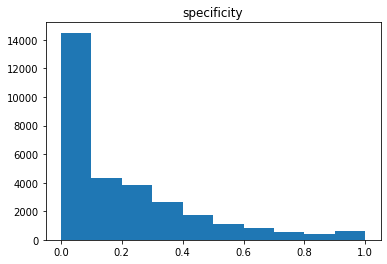

In [25]:
plt.hist(
    data_cp['specificity']
)
plt.title("specificity")
plt.show()

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


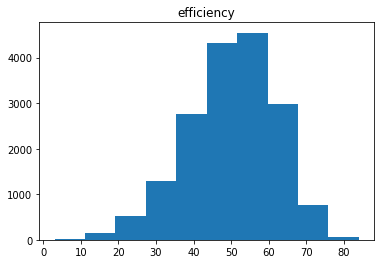

In [26]:
plt.hist(
    data_cp['efficiency']
)
plt.title("efficiency")
plt.show()

In [27]:
spe_bins = np.nanquantile(data_cp[ data_cp['specificity'] > 0.0 ]['specificity'],[0.25,0.5,0.75])
data_cp = data_cp.assign(specificity_bin=np.digitize(data_cp['specificity'],spe_bins))
print(spe_bins)
spe_bins = np.nanquantile(data_cp['efficiency'],[0.25,0.5,0.75])
data_cp = data_cp.assign(efficiency_bin=np.digitize(data_cp['efficiency'],spe_bins))
print(spe_bins)

[0.17146377 0.2766837  0.4505849 ]
[43. 51. 57.]


In [28]:
spe_bins

array([43., 51., 57.])

In [29]:
data_cp = data_cp.reset_index()
data_cp.columns = ['Coordinates']+list(data_cp.columns[1:])

tidy_data = get_tidy_table(data_cp, ['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3'])
tidy_data = tidy_data[ ~tidy_data['obs'].isnull() ]

Finished G1R1
Finished G1R2
Finished H6R1
Finished H6R2
Finished FUL1
Finished FUL2
Finished ABC1
Finished ABC2
Finished ABC3


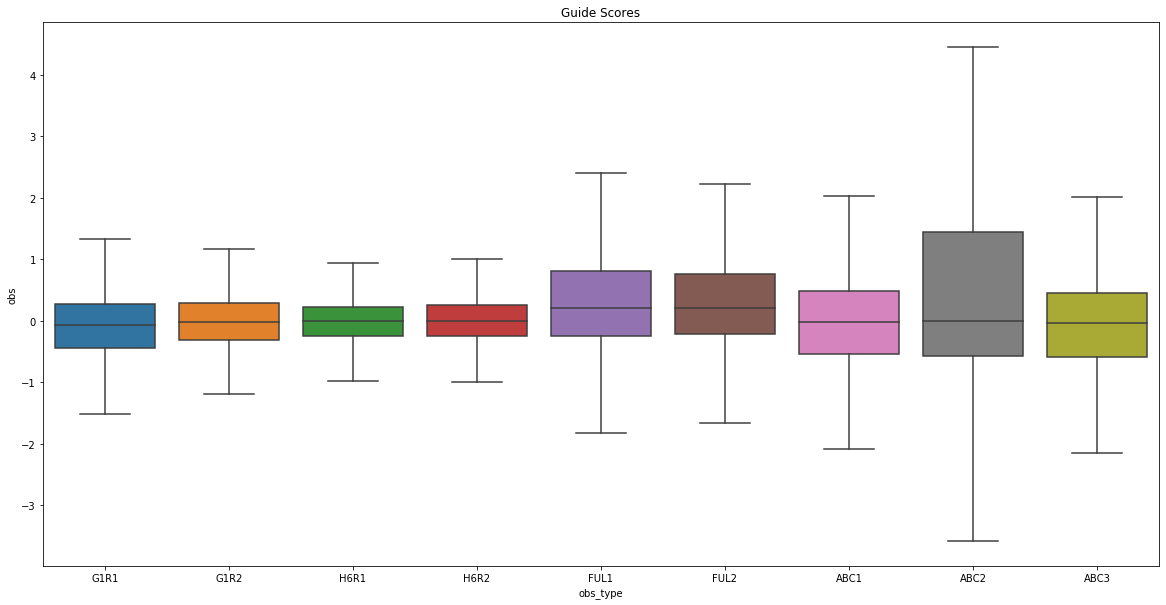

In [30]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_data, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('marginal_guide_score_distributions.pdf')

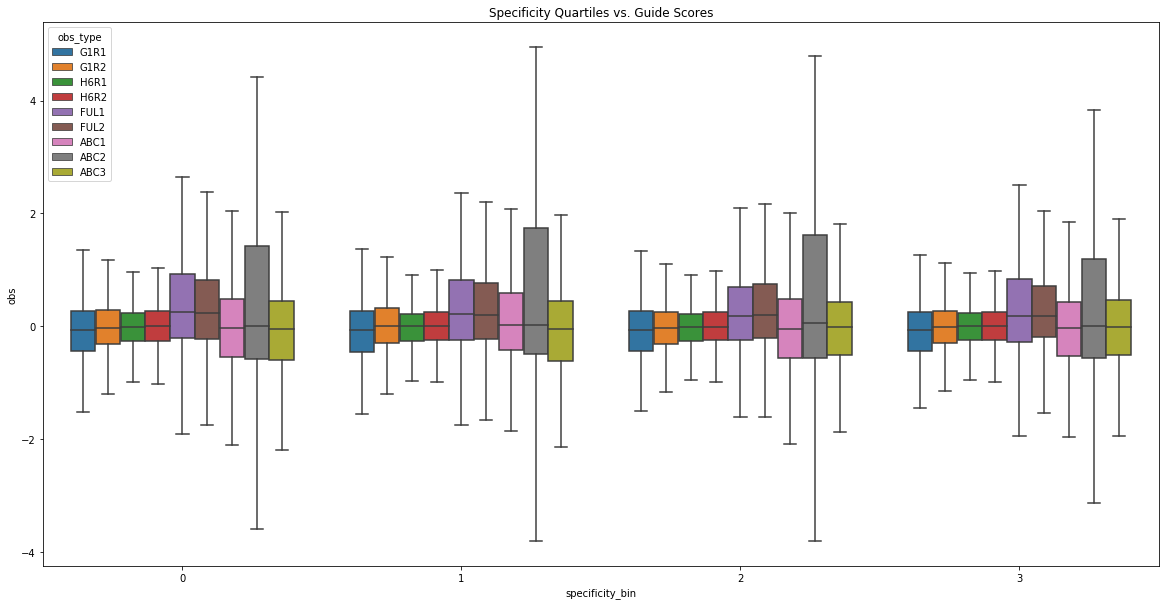

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

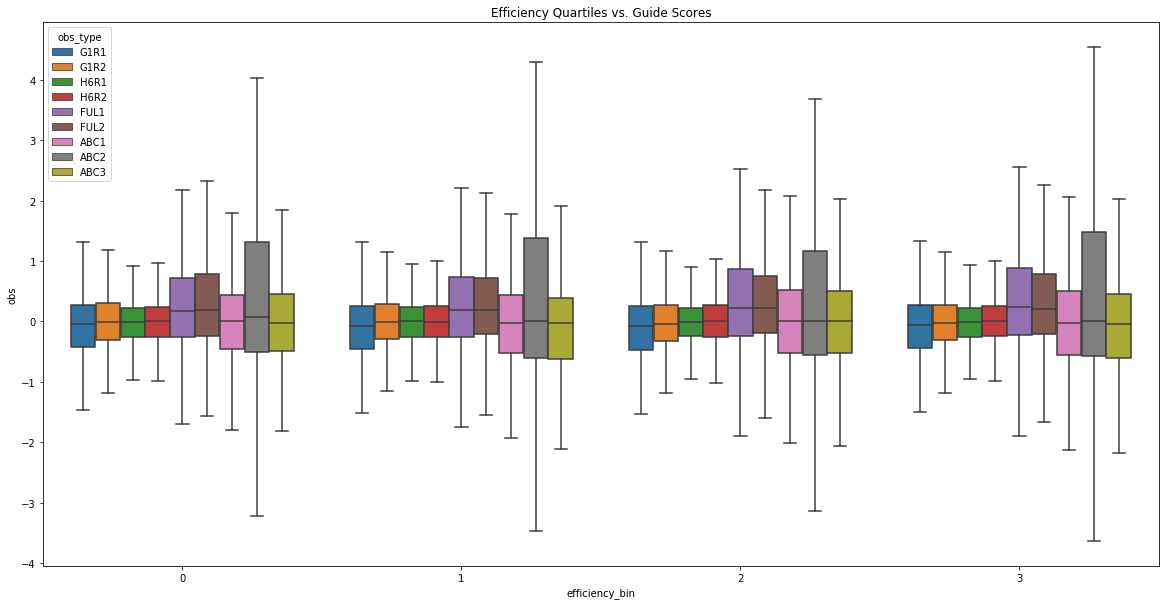

In [32]:
plt.figure(figsize=(20,10))
sns.boxplot(x='efficiency_bin',y='obs',hue='obs_type',data=tidy_data, showfliers = False) \
  .set_title("Efficiency Quartiles vs. Guide Scores");

Text(0.5, 1.0, 'Specificity Quartiles vs. Growth Guide Scores')

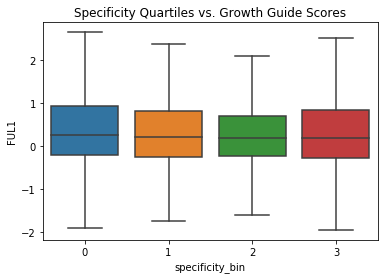

In [33]:
sns.boxplot(x='specificity_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False) \
   .set_title("Specificity Quartiles vs. Growth Guide Scores")

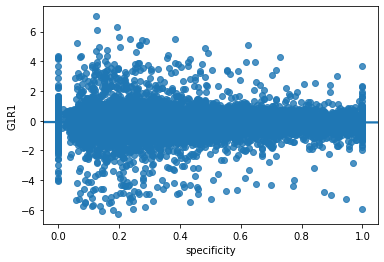

In [34]:
sns.regplot(x='specificity',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

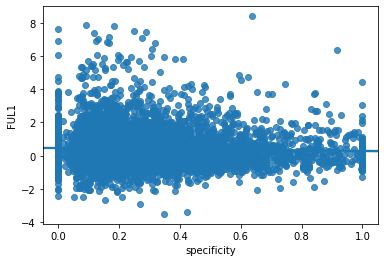

In [35]:
sns.regplot(x='specificity',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

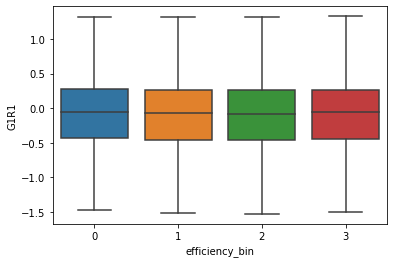

In [36]:
sns.boxplot(x='efficiency_bin',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ], showfliers = False)

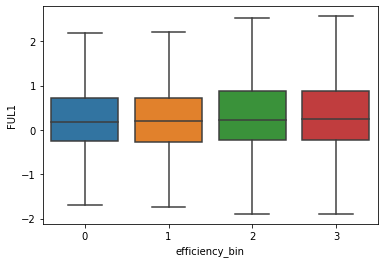

In [37]:
sns.boxplot(x='efficiency_bin',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ], showfliers = False)

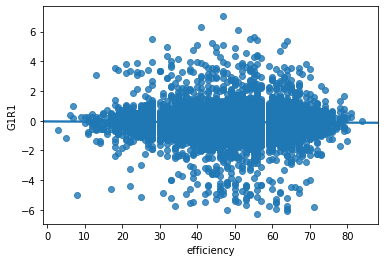

In [38]:
sns.regplot(x='efficiency',y='G1R1',data=data_cp[ ~data_cp['G1R1'].isna() ])

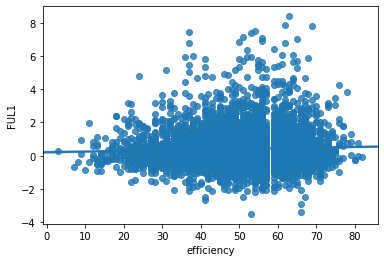

In [39]:
sns.regplot(x='efficiency',y='FUL1',data=data_cp[ ~data_cp['FUL1'].isna() ])

## Filter by Fulco reported Peaks

In [40]:
GATA_filter = pd.read_table('../data/ABC_rep1__sigPeaks.bed',usecols=[0,1,2],names=['chr','start','end'])

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [41]:
tidy_inPeaks = []
for item in tidy_data.iterrows():
    check = sum(check_overlap([item[1]['cutsite'], item[1]['cutsite']+1],
                              GATA_filter.loc[:,('start','end')].values))
    if check > 0:
        tidy_inPeaks.append(item[1])
    if (item[0] + 1) % 50000 == 0:
        print("finished {} rows".format(item[0]+1))

tidy_inPeaks = pd.DataFrame(tidy_inPeaks).reset_index(drop=True)

finished 100000 rows
finished 150000 rows
finished 200000 rows


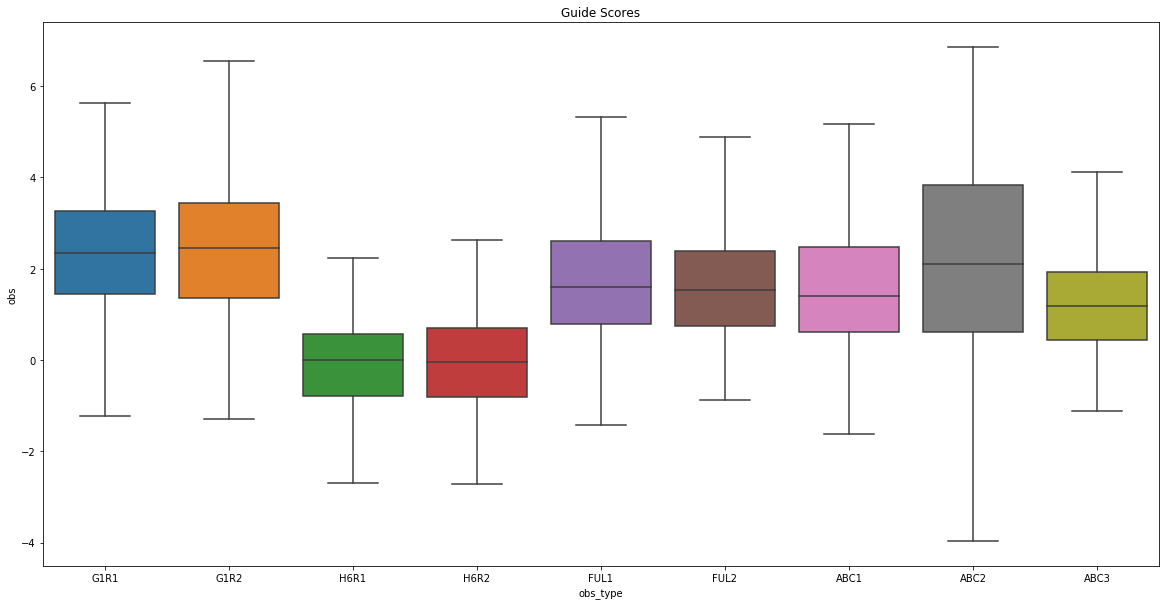

In [42]:
plt.figure(figsize=(20,10))
sns.boxplot(x='obs_type',y='obs',data=tidy_inPeaks, showfliers = False) \
  .set_title("Guide Scores");

plt.savefig('inPeak_guide_score_distributions.pdf')

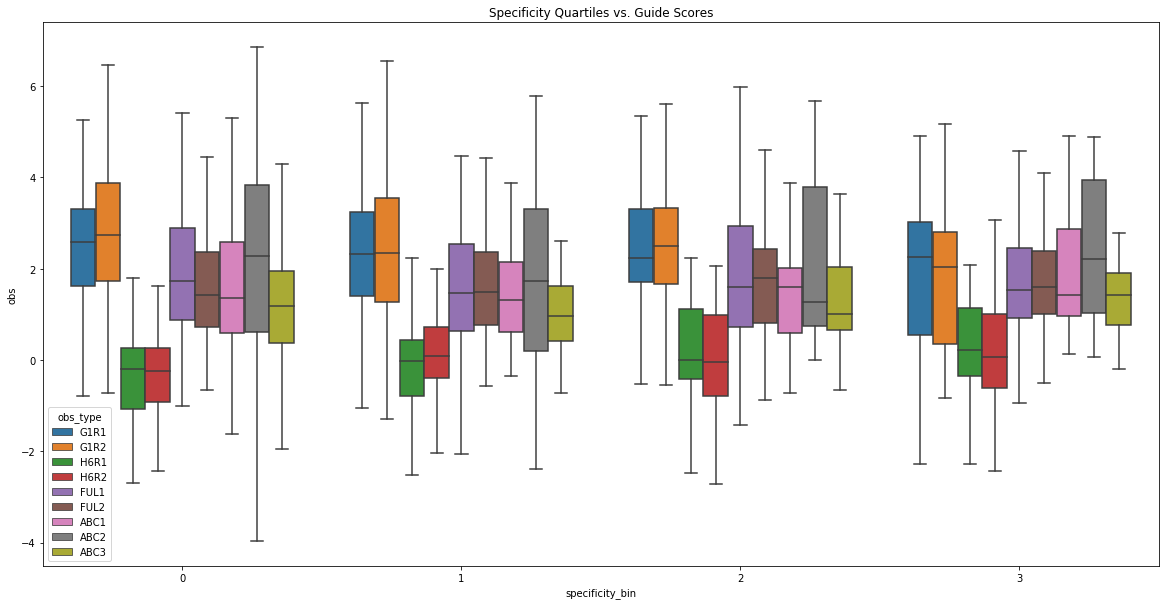

In [43]:
plt.figure(figsize=(20,10))
sns.boxplot(x='specificity_bin',y='obs',hue='obs_type',data=tidy_inPeaks, showfliers = False) \
  .set_title("Specificity Quartiles vs. Guide Scores");

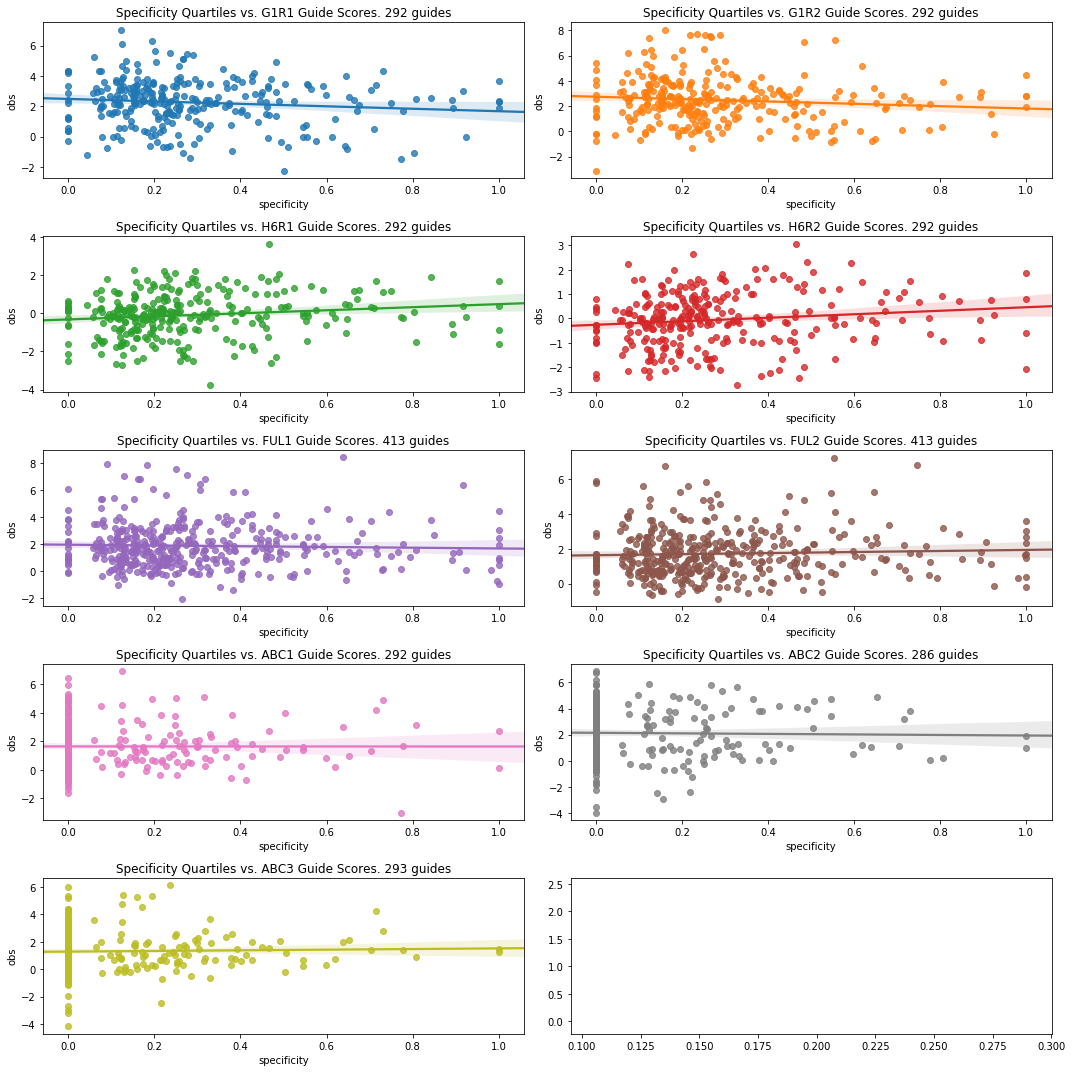

In [44]:
f, axes = plt.subplots(5, 2,figsize=(15,15))
for i,rep_tag in enumerate(['G1R1','G1R2','H6R1','H6R2','FUL1','FUL2','ABC1','ABC2','ABC3']):
    guide_ct = tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ].shape[0]
    sns.regplot(x='specificity',y='obs',
                data=tidy_inPeaks[ tidy_inPeaks['obs_type'] == rep_tag ],ax=axes[i//2,i%2]) \
      .set_title("Specificity Quartiles vs. {} Guide Scores. {} guides".format(rep_tag, guide_ct))

plt.tight_layout()
plt.show()

### Fulco signal track

In [45]:
targ_data = fulc.loc[ fulc.index != 'NT' ]
plus_offsets = [152, 147]
minus_offsets= [146, 153]
pos_array = np.array([ [ int(coord.split(':')[1].split('-')[1]) - plus_offsets[0],
                         int(coord.split(':')[1].split('-')[1]) + plus_offsets[1] ] if coord.split(':')[2] == '+' 
                       else [ int(coord.split(':')[1].split('-')[1]) - minus_offsets[0],
                              int(coord.split(':')[1].split('-')[1]) + minus_offsets[1] ]
                       for coord in targ_data.index ])

In [46]:
merged_pos = merge_intervals(pos_array)

In [47]:
genome_lims = (np.min(pos_array), np.max(pos_array))
print("{}-{}={}".format(genome_lims[1], genome_lims[0], genome_lims[1] - genome_lims[0]))


48821431-48745125=76306


In [48]:
nt_data = np.zeros( shape=[0, 5] )
last_start    = genome_lims[0]
last_subset = targ_data[ (pos_array[:,0] <= last_start) * (pos_array[:,1] > last_start) ]
ep = 1e-200 # epsilon for stability

for i, segment in enumerate( merged_pos ):
    if i == (merged_pos.shape[0]-1):
        segment[1] += 1
    for j, nt_pos in enumerate( range(*segment) ):
        nt_subset = targ_data[ (pos_array[:,0] <= nt_pos) * (pos_array[:,1] > nt_pos) ]
        if not nt_subset.index.equals(last_subset.index):
            score1 = last_subset[ 'FUL1' ].sum()
            score2 = last_subset[ 'FUL2' ].sum()
            new_entry = np.array([[last_start, last_nt+1, last_subset.shape[0], score1, score2]])
            nt_data = np.concatenate([nt_data,new_entry])
            last_start = nt_pos
        last_subset = nt_subset
        last_nt     = nt_pos
    if i % 20 == 0:
        print("On chunk [{}/{}]".format(i,merged_pos.shape[0]))


On chunk [0/38]
On chunk [20/38]


In [49]:
nt_data = pd.DataFrame(nt_data,columns=["start","stop","guide_count","rep1","rep2"])
nt_data[["start","stop","guide_count"]] = nt_data[["start","stop","guide_count"]].astype(np.int64)

In [50]:
nt_data.to_csv("Fulco_screen__score_track.txt", sep="\t", quoting=csv.QUOTE_NONE, index=False)